In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [3]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [30]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .4 .25; .045 .15 .43]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2]
Σ = [Σ1, Σ2]

transition_matrix = [.98 .02;.05 .95]

states_zero = [.3, .7]
X = [.12, .06]



n_steps = 500
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

500×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0432469   0.0257685
  0.0345366   0.0572523
 -0.0865787   0.0418278
  0.208934    0.0908935
  0.150642    0.106756
  0.031034    0.119419
 -0.0126914   0.114562
 -0.0459751   0.0808417
  0.0742686   0.0610528
 -0.00696275  0.0331695
  ⋮           
  0.256492    0.155607
  0.261088    0.209526
  0.1907      0.205629
  0.299021    0.200385
  0.148433    0.131578
  0.198896    0.096886
  0.14016     0.146354
  0.190316    0.159501
  0.23774     0.114185

In [31]:
regime_count = count_regime_transitions(test_regimes, 2) 
regime_count ./ sum(regime_count, dims=2)

2×2 Matrix{Float64}:
 0.991379  0.00862069
 0.142857  0.857143

In [32]:
display(count(x -> x==1, test_regimes))
unconditional_regimes(transition_matrix)

465

2-element Vector{Float64}:
 0.7142857142857144
 0.2857142857142857

In [33]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [34]:
r = 1
display("regime count")
display(count(x -> x==r, test_regimes)/n_steps)

Ym = filter_X(Y, test_regimes[2:end], r)
Xm = filter_X(X, test_regimes[2:end], r)
Beta_mean = inv(Xm' * Xm) * Xm' * Ym
display(Beta_mean') 

display("true beta")
display(Β[r])

"regime count"

0.93

2×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0809681  0.397959  0.190346
 0.0353977  0.114495  0.542092

"true beta"

2×3 Matrix{Float64}:
 0.09  0.3  0.2
 0.03  0.1  0.6

In [35]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)
t_m = zeros(n, 2, 2)

states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
t_m[1, :, :] = sample_transition_matrix(states[1, :], k)

for s in 2:n
    states_zero = unconditional_regimes(t_m[s-1, :, :])
    states[s, :] = simulate_regimes(Y, X, Β, Σ, t_m[s-1, :, :], states_zero)
    t_m[s, :, :] = sample_transition_matrix(states[s, :], k)    
end 

r1 = [count(x -> x ==1, states[:,t]) for t in 1:n_steps-1] / n
display(r1)
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

499-element Vector{Float64}:
 0.8596
 0.8292
 0.8586
 0.8776
 0.865
 0.8722
 0.8928
 0.9576
 0.9738
 0.989
 ⋮
 0.9976
 0.9954
 0.9976
 0.9974
 0.9968
 0.9966
 0.9956
 0.9938
 0.9902

"transition matrix"

2×2 Matrix{Float64}:
 0.987838  0.0121621
 0.124259  0.875741

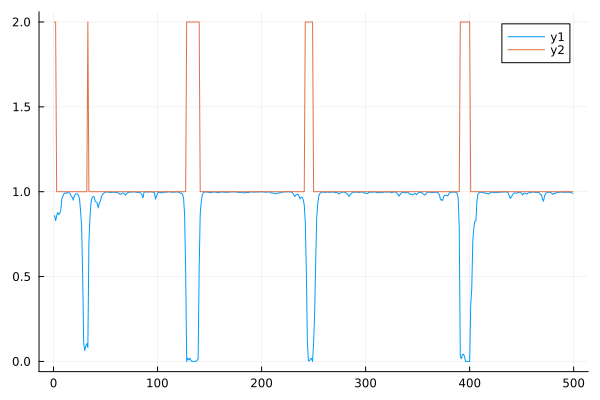

In [36]:
plot(r1)
plot!(test_regimes[2:end])

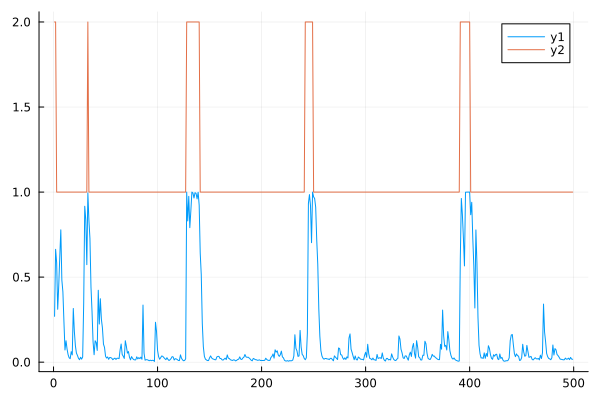

In [37]:
states_zero = [.6, .4]
regimes_probs = hamilton_filter(Y,X, Β, Σ, transition_matrix, states_zero)

plot(regimes_probs[:,2])
plot!(test_regimes[2:end])

In [38]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)


states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
cov_sample = [sample_covariance(Y, X, Β, states[1,:], k)] 

for s in 2:n
    states_zero = unconditional_regimes(transition_matrix)
    states[s, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
    push!(cov_sample, sample_covariance(Y, X, Β, states[s,:], k))    
end 

cov1_mean = mean(map(x -> x[1], cov_sample))
cov2_mean = mean(map(x -> x[2], cov_sample))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.08064429832013352
 0.031990866520262125

"regime two"

2-element Vector{Float64}:
 0.18172635716846613
 0.03924611884087998

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.308266
 0.308266  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.447334
 0.447334  1.0

In [39]:
n_burn = 20_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, transition_matrix, [Β0', Β0'], [Σ0, Σ0], n_burn, n_sample)

([2 2 … 1 1; 1 1 … 1 1; … ; 2 2 … 1 1; 2 2 … 1 1], [0.9932521914598849 0.12084743145926012; 0.9880835278477084 0.11972726046805011; … ; 0.9935718032221709 0.06036069945314279; 0.9934859818993612 0.1332714564672895;;; 0.006747808540115037 0.8791525685407398; 0.01191647215229171 0.8802727395319498; … ; 0.006428196777829016 0.9396393005468573; 0.006514018100638682 0.8667285435327106], Vector{Any}[[[0.07115330870511302 0.4441014596377925 0.18896972548076615; 0.02915190470793846 0.14906070856418224 0.5355709902823732], [-0.23743091911872385 -0.24697646214952002 2.400061555904576; 0.048496681244228346 0.16264729170155617 0.3709799592589521]], [[0.06559362278877354 0.4029913201122755 0.29389216262377604; 0.027658488570859396 0.15166636080657386 0.5453294166709095], [0.004033314486479105 0.5931507492017283 -0.7869412333363142; 0.10110840733853774 0.25436111595519384 -0.200953907186408]], [[0.07370648926290302 0.4973130079419291 0.09304641302977129; 0.0283245818308426 0.15400514126628495 0.5232

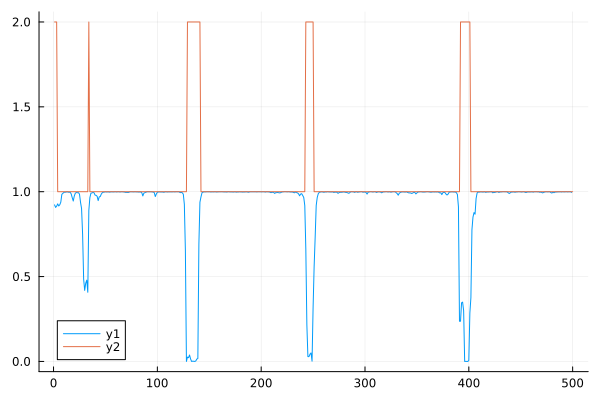

In [40]:
r1 = [count(x -> x ==1, regimes[:,t]) for t in 1:n_steps-1] / n_sample

plot(r1)
plot!(test_regimes)

In [41]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"transition matrix"

2×2 Matrix{Float64}:
 0.989977  0.0100233
 0.132824  0.867176

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 0.0822925  0.391048  0.193262
 0.0334638  0.122356  0.545771

"regime two"

2×3 Matrix{Float64}:
 0.00814979  0.326671  -0.576451
 0.0751125   0.165772   0.098106

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.08174930582388068
 0.032044522221167625

"regime two"

2-element Vector{Float64}:
 0.19904082090094818
 0.04052743953713096

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.311453
 0.311453  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0      0.43945
 0.43945  1.0